In [18]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
base_dir = '/content/loan_data.csv'
df = pd.read_csv(base_dir)
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
df = df.dropna()  # or use imputation if data loss is significant


In [6]:
df = pd.get_dummies(df, columns=[
    'person_gender', 'person_education', 'person_home_ownership',
    'loan_intent', 'previous_loan_defaults_on_file'
])

In [7]:
scaler = StandardScaler()
num_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
            'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

df[num_cols] = scaler.fit_transform(df[num_cols])


In [10]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8313 - loss: 0.3626 - val_accuracy: 0.8972 - val_loss: 0.2199
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9009 - loss: 0.2186 - val_accuracy: 0.9046 - val_loss: 0.2094
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9060 - loss: 0.2080 - val_accuracy: 0.9087 - val_loss: 0.2027
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9129 - loss: 0.1953 - val_accuracy: 0.9107 - val_loss: 0.1985
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9164 - loss: 0.1912 - val_accuracy: 0.9136 - val_loss: 0.1948
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9160 - loss: 0.1908 - val_accuracy: 0.9129 - val_loss: 0.1930
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9170 - loss: 0.1872 - val_accuracy: 0.9146 - val_loss: 0.1924
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9180 - loss: 0.1850 - val_accuracy: 0.

In [20]:
import numpy as np

# Predict probabilities
y_probs = model.predict(X_test)

# Convert to binary predictions
y_pred = (y_probs > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7000
           1       0.88      0.74      0.81      2000

    accuracy                           0.92      9000
   macro avg       0.91      0.86      0.88      9000
weighted avg       0.92      0.92      0.92      9000



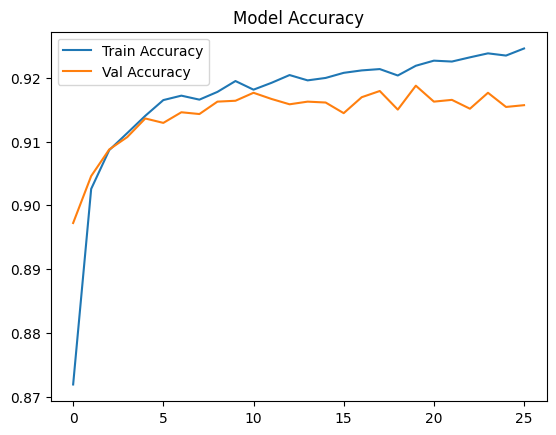

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

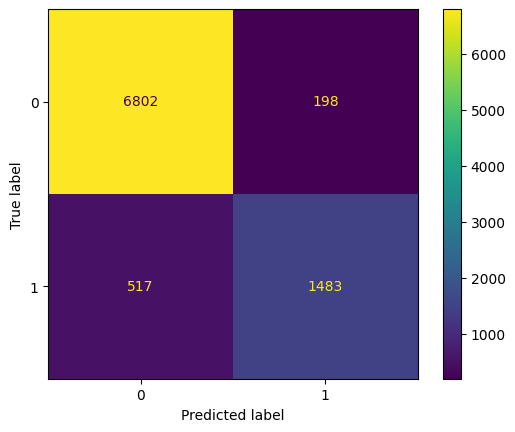

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

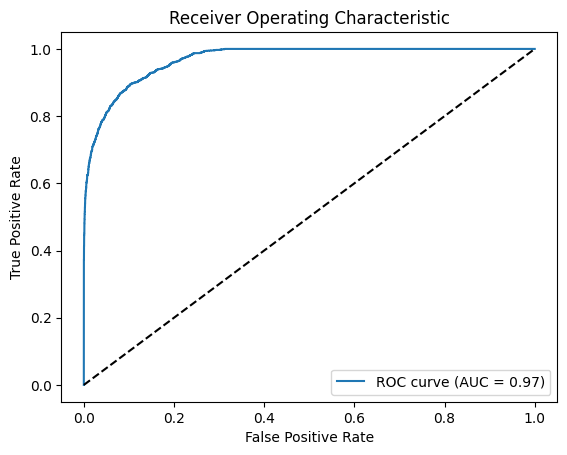

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
model.save('mlp.h5')

In [23]:
model.save('mlp.keras')